In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

test = pd.read_csv('/Users/firat/Development/Machine Learning/ml.titanic/test.csv', header=0)
train = pd.read_csv('/Users/firat/Development/Machine Learning/ml.titanic/train.csv', header=0)

# Convert cabin literals to string, 
# then take first letter from each one of them, 
# then put it back to dataset
cabinAsString = train["Cabin"].astype(str)
tempCabin = np.array([cabin[0] for cabin in cabinAsString])
train["Cabin"] = pd.Categorical(tempCabin)

# Find mean age and put it to missing fields
meanAge = np.around(np.mean(train["Age"]))
tempAge = np.where(train["Age"].isnull(), meanAge, train["Age"])
train["Age"] = tempAge

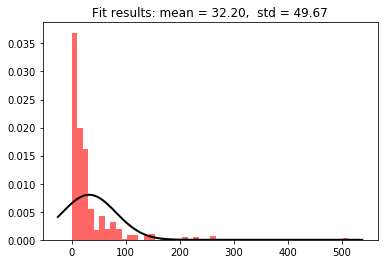

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [2]:
from scipy.stats import norm
data = train["Fare"]
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=50, normed=True, alpha=0.6, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()
print(data.describe())

In [3]:
if train["Fare"][0] != 0:
    train['Fare'].fillna(train['Fare'].dropna().mode()[0], inplace=True)
    fare = []
    for i in train["Fare"]:
        if i <= 7.910400:
            fare = np.append(fare,0)
        elif i < 14.454200:
            fare = np.append(fare,1)
        elif i < 31.000000:
            fare = np.append(fare,2)
        else:
            fare = np.append(fare,3)
train["Fare"] = fare = fare.astype(int)

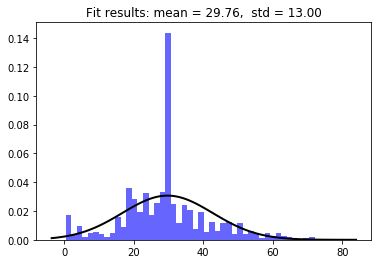

count    891.000000
mean      29.758889
std       13.002570
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


In [4]:
data = train["Age"]
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=50, normed=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()
print(data.describe())

In [5]:
#if train["Age"][0] != 0:
#    train['Age'].fillna(train['Age'].dropna().mode()[0], inplace=True)
#    age = []
#    for i in train["Age"]:
#        if i <= 22.000000:
#            age = np.append(age,0)
#        elif i < 30.000000:
#            age = np.append(age,1)
#        elif i < 35.000000:
#            age = np.append(age,2)
#        else:
#            age = np.append(age,3)
#train["Age"] = age = age.astype(int)

In [6]:
from sklearn import linear_model
from sklearn import preprocessing

In [7]:
# Convert sex, embark and cabin literals to numbers
le = preprocessing.LabelEncoder()
sexEnc = le.fit_transform(train["Sex"])
train["Sex"] = sexEnc

embEnc = le.fit_transform(train["Embarked"].astype(str))
train["Embarked"] = embEnc

cabEnc = le.fit_transform(train["Cabin"].astype(str))
train["Cabin"] = cabEnc

# Apart from name and ticket number, our data is ready

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0,8,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,3,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,1,8,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3,2,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,1,8,2


# We can use logistic model now for predicting survival based on ticket class, age, sex, fare, cabin and embarked port

### Cabin vs Survival

In [9]:
log_model = linear_model.LogisticRegression()
log_model.fit(X = pd.DataFrame(sexEnc), y = train["Survived"])

# Check trained model intercept
print(log_model.intercept_)

# Check trained model coefficients
print(log_model.coef_)

[ 1.00027876]
[[-2.43010712]]


### Here we will use these literals in logistic regression function:
    B0 = 1.00027876
    B1 = -2.43010712

<img src="log_reg_func.png" width="240" height="240" align="left"/>


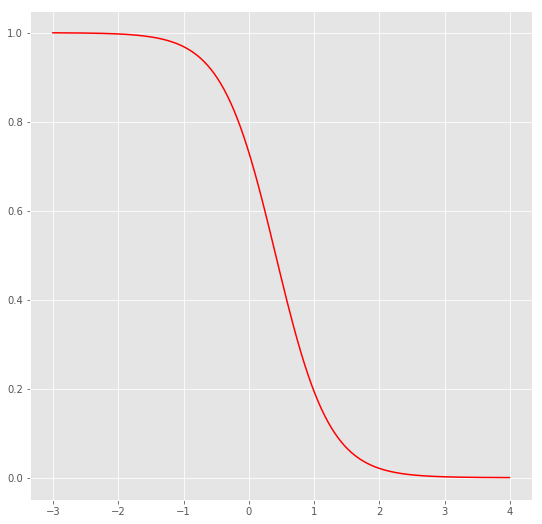

In [10]:
matplotlib.style.use('ggplot')
plt.figure(figsize=(9,9))

def sigmoid(t):
    return (1/(1 + np.e**(-(1.00027876 + (-2.43010712*t)))))    

plot_range = np.arange(-3, 4, 0.01)       

y_values = sigmoid(plot_range)

# Plot curve
plt.plot(plot_range, y_values, color="red")

In [11]:
preds = log_model.predict_proba(X= pd.DataFrame(sexEnc))
preds = pd.DataFrame(preds)
preds.columns = ["Death_prob", "Survival_prob"]
pd.crosstab(train["Sex"], preds.loc[:, "Survival_prob"])

Survival_prob,0.193125428972,0.731113382332
Sex,,
0,0,314
1,577,0


Here, our model presents 73% of female survival and 19% of male survival.

In [12]:
# Convert more variables to numeric
clsEnc = le.fit_transform(train["Pclass"])


train_features = pd.DataFrame([clsEnc,
                              cabEnc,
                              sexEnc,
                              train["Age"]]).T

# Initialize logistic regression model
log_model = linear_model.LogisticRegression()

# Train the model
log_model.fit(X = train_features ,
              y = train["Survived"])

# Check trained model intercept
print(log_model.intercept_)

# Check trained model coefficients
print(log_model.coef_)

[ 3.33546355]
[[-0.90445253 -0.06425681 -2.4295509  -0.02670905]]


In [13]:
# Make predictions
preds = log_model.predict(X= train_features)

# Generate table of predictions vs actual
pd.crosstab(preds,train["Survived"])

Survived,0,1
row_0,,
0,465,101
1,84,241


In [18]:
acc = ((465+241)/889)
print("Our accurcy is:  %.2f" % (acc))

Our accurcy is:  0.79


In [20]:
char_cabin = test["Cabin"].astype(str)     # Convert cabin to str

new_Cabin = np.array([cabin[0] for cabin in char_cabin]) # Take first letter

test["Cabin"] = pd.Categorical(new_Cabin)  # Save the new cabin var

# Impute median Age for NA Age values
new_age_var = np.where(test["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       test["Age"])      # Value if check is false

test["Age"] = new_age_var 

In [23]:
# Convert test variables to match model features
encoded_sex = le.fit_transform(test["Sex"])
encoded_class = le.fit_transform(test["Pclass"])
encoded_cabin = le.fit_transform(test["Cabin"])

test_features = pd.DataFrame([encoded_class,
                              encoded_cabin,
                              encoded_sex,
                              test["Age"]]).T

In [26]:
# Make test set predictions
test_preds = log_model.predict(X=test_features)

# Create a submission for Kaggle
submission = pd.DataFrame({"PassengerId":test["PassengerId"],
                           "Survived":test_preds})

# Save submission to CSV
submission.to_csv("logreg_submission.csv", 
                  index=False)        # Do not save index values